In [1]:
from dotenv import load_dotenv
import sys

sys.path.append("../../common")
load_dotenv()

True

In [2]:
import os
from langsmith_tracker import set_tracking

# 인스턴스를 생성할 때 필요한 매개변수를 전달합니다.
set_tracking(project_name="17.LangGraph")

Langsmith 추적이 활성화되었습니다. [프로젝트명: 17.LangGraph]


### LangGraph Streaming Outputs

LangGraph의 Streaming Outputs 은 LLM의 Streaming Token 출력과는 다른 기능입니다.  
  
LangGraph의 Streaming Outputs 는 노드의 출력을 스트리밍하여 출력하는 기능입니다.  
  
LangGraph에서도 Token Streaming 기능을 사용할 수 있습니다. 그 기능은 추후에 Streaming Step 에서 다루도록 하겠습니다.  

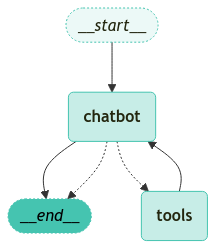

In [31]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict

from langchain_core.tools import tool
from langchain_openai import ChatOpenAI
from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.prebuilt import ToolNode, tools_condition
from graphs import visualize_graph
from tools_news import GoogleNews


##### 1. 상태(State) 정의
class State(TypedDict):
    # 메모리 저장소 추가
    messages: Annotated[list, add_messages]
    dummy_data: Annotated[str, "dummy"]


##### 2. 도구 정의 및 바인딩
# 도구 초기화
news_tool = GoogleNews()


@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=5)


tools = [search_keyword]

# llm 초기화
llm = ChatOpenAI(model="gpt-4o-mini", temperature=0)

# llm과 도구 바인딩
llm_with_tools = llm.bind_tools(tools)


##### 3. 노드 추가
# 챗봇 함수 정의, 노드 정의
def chatbot(state: State):
    # 메시지 호출 및 반환
    return {
        "messages": llm_with_tools.invoke(state["messages"]),
        "dummy_data": "[chatbot] 호출, dummy data",  # 더미 추가
    }


# 상태 그래프 생성
graph_builder = StateGraph(State)

# 챗봇 노드 추가
graph_builder.add_node("chatbot", chatbot)

# 도구 노드 생성 및 추가
tool_node = ToolNode(tools=tools)

# 도구 노드 추가
graph_builder.add_node("tools", tool_node)

# 조건부 엣지
graph_builder.add_conditional_edges(
    "chatbot",
    tools_condition,
)

##### 4. 엣지 추가
# START > chatbot
graph_builder.add_edge(START, "chatbot")

# tools > chatbot
graph_builder.add_edge("tools", "chatbot")

# chatbot > END
graph_builder.add_edge("chatbot", END)

##### 5. 그래프 컴파일
graph = graph_builder.compile()

##### 6. 그래프 시각화
visualize_graph(graph)

#### StateGraph의 `stream` 메서드

`stream` 메서드는 단일 입력에 대한 그래프 단계를 스트리밍하는 역할을 합니다.

**매개변수**  
- **`input`** *(Union[dict[str, Any], Any])*: 그래프에 대한 입력
- **`config`** *(Optional[RunnableConfig])*: 실행 구성
- **`stream_mode`** *(Optional[Union[StreamMode, list[StreamMode]]])*: 출력 스트리밍 모드
- **`output_keys`** *(Optional[Union[str, Sequence[str]]])*: 스트리밍할 키
- **`interrupt_before`** *(Optional[Union[All, Sequence[str]]])*: 실행 전에 중단할 노드
- **`interrupt_after`** *(Optional[Union[All, Sequence[str]]])*: 실행 후에 중단할 노드
- **`debug`** *(Optional[bool])*: 디버그 정보 출력 여부
- **`subgraphs`** *(bool)*: 하위 그래프 스트리밍 여부

**반환값**
- **Iterator[Union[dict[str, Any], Any]]**: 그래프의 각 단계 출력.   
  출력 형태는 **`stream_mode`**에 따라 다름.

**주요 기능**
1. 입력된 설정에 따라 그래프 실행을 스트리밍 방식으로 처리.
2. 다양한 스트리밍 모드 지원 (**`values`, `updates`, `debug`**).
3. 콜백 관리 및 오류 처리.
4. 재귀 제한 및 중단 조건 처리.

**스트리밍 모드**
- **`values`**: 각 단계의 현재 상태 값 출력
- **`updates`**: 각 단계의 상태 업데이트만 출력
- **`debug`**: 각 단계의 디버그 이벤트 출력

In [32]:
from langchain_core.runnables import RunnableConfig

# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 상태를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-tag"],  # Tag
)

config를 설정하고 streaming을 진행합니다.

In [44]:
for event in graph.stream(input=input, config=config):
    for key, value in event.items():
        print(f"\n[ {key} ]\n")
        # value 에 messages 가 존재하는 경우
        if "messages" in value:
            messages = value["messages"]
            # 가장 최근 메시지 1개만 출력합니다.
            value["messages"][-1].pretty_print()


[ chatbot ]

================================== Ai Message ==================================
Tool Calls:
  search_keyword (call_8jd18JLsJX7h7iwhqUTngyek)
 Call ID: call_8jd18JLsJX7h7iwhqUTngyek
  Args:
    query: 2024 Nobel Prize in Literature

[ tools ]

================================= Tool Message =================================
Name: search_keyword

[{"url": "https://news.google.com/rss/articles/CBMinwJBVV95cUxQUkpKOVpqWEo2MnN0N0RpRHdhUWVzUFVwT0RIclZYSjlaUmJUYWtYU3N3U2ROOWdUejR4WC00WkoxdHlDSzlDNVZGdkctNjk2WlRVc0h5YkxDSm1nNHJwQUYxcTNfcm92X0xMNGFMWUJFSnlqcEo0NHZxWkJoSkdtWmdSaXVma3JJSnNKR09YS2wxQ01kN18zUmF0cXlTV2VqTk1jcEJTenBnRHpJbGVYbWJiVTNtc2tfMFY1Tmo5Nl9LMVBwV1ZWMXltdHlMcnltTGlxT21ObmZqQjFGVllMRGc2N3lNakE4RTRjZG8tdDhQRkNZQlhfNFFiaGNYQU8yVERLYjhuSW50YkNPY3JZZ2twaVBhNmZLUmxpUGFqYw?oc=5", "content": "The Nobel Prize in Literature 2024 - NobelPrize.org"}, {"url": "https://news.google.com/rss/articles/CBMiU0FVX3lxTE5wc21Bam9IYjZHbDdXZVIya2xKQm1GSmo0dzhzM0RvY2lEMzVldlRlTzF0M1BlVEhUW

#### `output_keys` 옵션

`output_keys` 옵션은 스트리밍할 키를 지정하는 옵션입니다.   
  
위에는 전체를 출력했다면, `output_keys` 옵션을 사용하여 확인해야할 내용만 필터링해서 볼 수 있도록 합니다.
  
list 형식으로 지정할 수 있으며, **channels 에 정의된 키 중 하나** 여야 합니다.  
  
**Tip.**  
- 매 단계마다 출력되는 State Key 가 많은 경우, 일부만 스트링하고 싶은 경우에 유용합니다.

In [34]:
print(list(graph.channels.keys()))

['messages', 'dummy_data', '__start__', 'chatbot', 'tools', 'branch:chatbot:__self__:chatbot', 'branch:chatbot:__self__:tools', 'branch:tools:__self__:chatbot', 'branch:tools:__self__:tools', 'start:chatbot', 'branch:chatbot:tools_condition:chatbot', 'branch:chatbot:tools_condition:tools']


dummy_data 에 있는 키로 stream 하는 예제입니다.

In [35]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 상태를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": "1"},
    tags=["my-tag"],
)

for event in graph.stream(input=input, config=config, output_keys=["dummy_data"]):
    print(f"\n {event} \n")

    for key, value in event.items():
        # dummy_data 가 존재하는 경우
        if value:
            # value 는 노드의 출력 값
            print("[ value ]", value.keys())

            # dummy_data의 key 가 존재하는 경우
            if "dummy_data" in value:
                print("[ dummy_data ]", value["dummy_data"])


 {'chatbot': {'dummy_data': '[chatbot] 호출, dummy data'}} 

[ value ] dict_keys(['dummy_data'])
[ dummy_data ] [chatbot] 호출, dummy data

 {'tools': None} 


 {'chatbot': {'dummy_data': '[chatbot] 호출, dummy data'}} 

[ value ] dict_keys(['dummy_data'])
[ dummy_data ] [chatbot] 호출, dummy data


#### `stream_mode` 옵션

`stream_mode` 옵션은 스트리밍 모드를 지정하는 옵션입니다.  
  
- values: 각 단계의 현재 상태 값 출력합니다.
- updates: 각 단계의 상태 업데이트만 출력합니다.
- debug: 각 단계의 디버그 이벤트 출력합니다.

##### `steam_mode` = "values" 로 설정하여 스트리밍 모드를 지정합니다.  

`values` 모드는 각 단계의 현재 상태 값을 출력합니다.



[ messages ]

메시지 개수: 1

[ dummy_data ]

==============================  단계  ==============================

[ messages ]

메시지 개수: 2

[ dummy_data ]

==============================  단계  ==============================

[ messages ]

메시지 개수: 3

[ dummy_data ]

==============================  단계  ==============================

[ messages ]

메시지 개수: 4

[ dummy_data ]

==============================  단계  ==============================


##### `stream_mode = "updates"`
updates 모드는 각 단계에 대한 업데이트된 State 만 내보냅니다.  
  
출력은 노드 이름을 key 로, 업데이트된 값을 values 으로 하는 dictionary 입니다.  

In [49]:
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

input = State(dummy_data="테스트 문자열", messages=[("user", question)])

config = RunnableConfig(
    recursion_limit=10,
    configurable={"thread_id": "1"},
    tags=["my-rag"],
)

for event in graph.stream(
    input=input,
    stream_mode="updates",
):
    for key, value in event.items():
        print(f"\n[ {key} ]\n")
        print(value.keys())

        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")
    print("===" * 10, " 단계 ", "===" * 10)


[ chatbot ]

dict_keys(['messages', 'dummy_data'])
메시지 개수: 1
==============================  단계  ==============================

[ tools ]

dict_keys(['messages'])
메시지 개수: 1
==============================  단계  ==============================

[ chatbot ]

dict_keys(['messages', 'dummy_data'])
메시지 개수: 1
==============================  단계  ==============================


##### `interrupt_before 와 interrupt_after 옵션`

`interrupt_before` 와 `interrupt_after` 옵션은 스트리밍 중단 시점을 지정하는 데 사용됩니다.

- `interrupt_before`: 지정된 노드 이전에 스트리밍 중단
- `interrupt_after`: 지정된 노드 이후에 스트리밍 중단


In [45]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",  # 기본값
    interrupt_before=["tools"],  # tools 노드 이전에 스트리밍 중단
):
    for key, value in event.items():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        # value 는 노드의 출력값
        if isinstance(value, dict):
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")
    print("===" * 10, " 단계 ", "===" * 10)


[chatbot]

dict_keys(['messages', 'dummy_data'])
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_QwlMbcZSCtx4Pj5PSZtyeYyE', 'function': {'arguments': '{"query":"2024년 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 57, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-ec4ec3ee-4d09-4152-ba72-86591186b4c3-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024년 노벨 문학상'}, 'id': 'call_QwlMbcZSCtx4Pj5PSZtyeYyE', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 21, 'total_tokens': 78, 'input_token_details': {'audio': 0

In [46]:
# 질문
question = "2024년 노벨 문학상 관련 뉴스를 알려주세요."

# 초기 입력 State 를 정의
input = State(dummy_data="테스트 문자열", messages=[("user", question)])

# config 설정
config = RunnableConfig(
    recursion_limit=10,  # 최대 10개의 노드까지 방문. 그 이상은 RecursionError 발생
    configurable={"thread_id": "1"},  # 스레드 ID 설정
    tags=["my-rag"],  # Tag
)

for event in graph.stream(
    input=input,
    config=config,
    stream_mode="updates",
    interrupt_after=["tools"],  # tools 실행 후 interrupt
):
    for value in event.values():
        # key 는 노드 이름
        print(f"\n[{key}]\n")

        if isinstance(value, dict):
            # value 는 노드의 출력값
            print(value.keys())
            if "messages" in value:
                print(value["messages"])

        # value 에는 state 가 dict 형태로 저장(values 의 key 값)
        if "messages" in value:
            print(f"메시지 개수: {len(value['messages'])}")


[__interrupt__]

dict_keys(['messages', 'dummy_data'])
[AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_z1HgsthHjpplGRAjKOgEahp3', 'function': {'arguments': '{"query":"2024년 노벨 문학상"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 57, 'total_tokens': 78, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-mini-2024-07-18', 'system_fingerprint': 'fp_bba3c8e70b', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-8898e306-3c35-42c2-b405-560109faf719-0', tool_calls=[{'name': 'search_keyword', 'args': {'query': '2024년 노벨 문학상'}, 'id': 'call_z1HgsthHjpplGRAjKOgEahp3', 'type': 'tool_call'}], usage_metadata={'input_tokens': 57, 'output_tokens': 21, 'total_tokens': 78, 'input_token_details': {'aud